In [1]:
## 20230519 NF/FF Flights with fixed pulsing cadence over WLC... (use WLC Site!)
## Group 1: ch0=Bicolog, ch1=Telescope_Y_NSpol
    ## 'FLY779.csv' - Altitude ~100m, Yaw ~0deg  --> FFNS
    ## 'FLY780.csv' - Altitude ~20m, Yaw ~0deg   --> NFNS20
    ## 'FLY781.csv' - Altitude ~18m, Yaw ~0deg   --> NFNS18
## Group 2: ch0=Telescope_X_EWpol, ch1=Bicolog
    ## 'FLY782.csv' - Altitude ~18m, Yaw ~90deg  --> NFEW18
    ## 'FLY783.csv' - Altitude ~20m, Yaw ~90deg  --> NFEW20
    ## 'FLY784.csv' - Altitude ~100m, Yaw ~90deg --> FFEW
    
## Changelog/Bug hunting notes:
# Solved timing bugs from clockless correlator operation:
    #1) recreated time axis from fpga_counts
    #2) changed WLC site read options to remove factor of 1e-9 on t0

##From loadD3Adata_Dallas.py:
from matplotlib.pyplot import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import numpy as np
import h5py
##From WT:
import datetime
import pytz
import os
import glob
from matplotlib import colors
import pandas
import csv
import pickle
%matplotlib inline
import beamcals
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
from beamcals import beammap
from beamcals import reduce_ccclass
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
import beamcals.reduce_ccclass as rc
from beamcals.sites import site
import yaml
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'


# Display settings:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
fly='533'

f = -1
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]

for fi in range(0,len(documents["flight_info"]["flights"])):
    if fly == flights[fi]: f = fi
print(f, 'FLIGHT: ', documents["flight_info"]["flights"][f])

fly = flights[f]
dtub = documents["flight_info"]["tubs"][f]
dtlb = documents["flight_info"]["tlbs"][f]
cdat = documents["flight_info"]["cdats"][f]
tclb = documents["flight_info"]["tclbs"][f]
tcub = documents["flight_info"]["tcubs"][f]
fmax = documents["flight_info"]["fmaxes"][f]

print(fly,dtlb,dtub,cdat,tclb,tcub,fmax)


0 FLIGHT:  533
533 1900 11000 20210826T182904Z 8500 20000 None


Initializing drone data via datcon_csv routine: FLY533.csv
  --> Skipping rows 1 to 2399 to eliminate NAN values
  --> Attempting to load position data from RTK
    --> RTK data contains 9100/9100 non-nan values
Timestamp interpolation succeeded
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.
plotting drone coordinates for all time samples:
overplotting drone coordinates for t_cut samples: [0:-1]


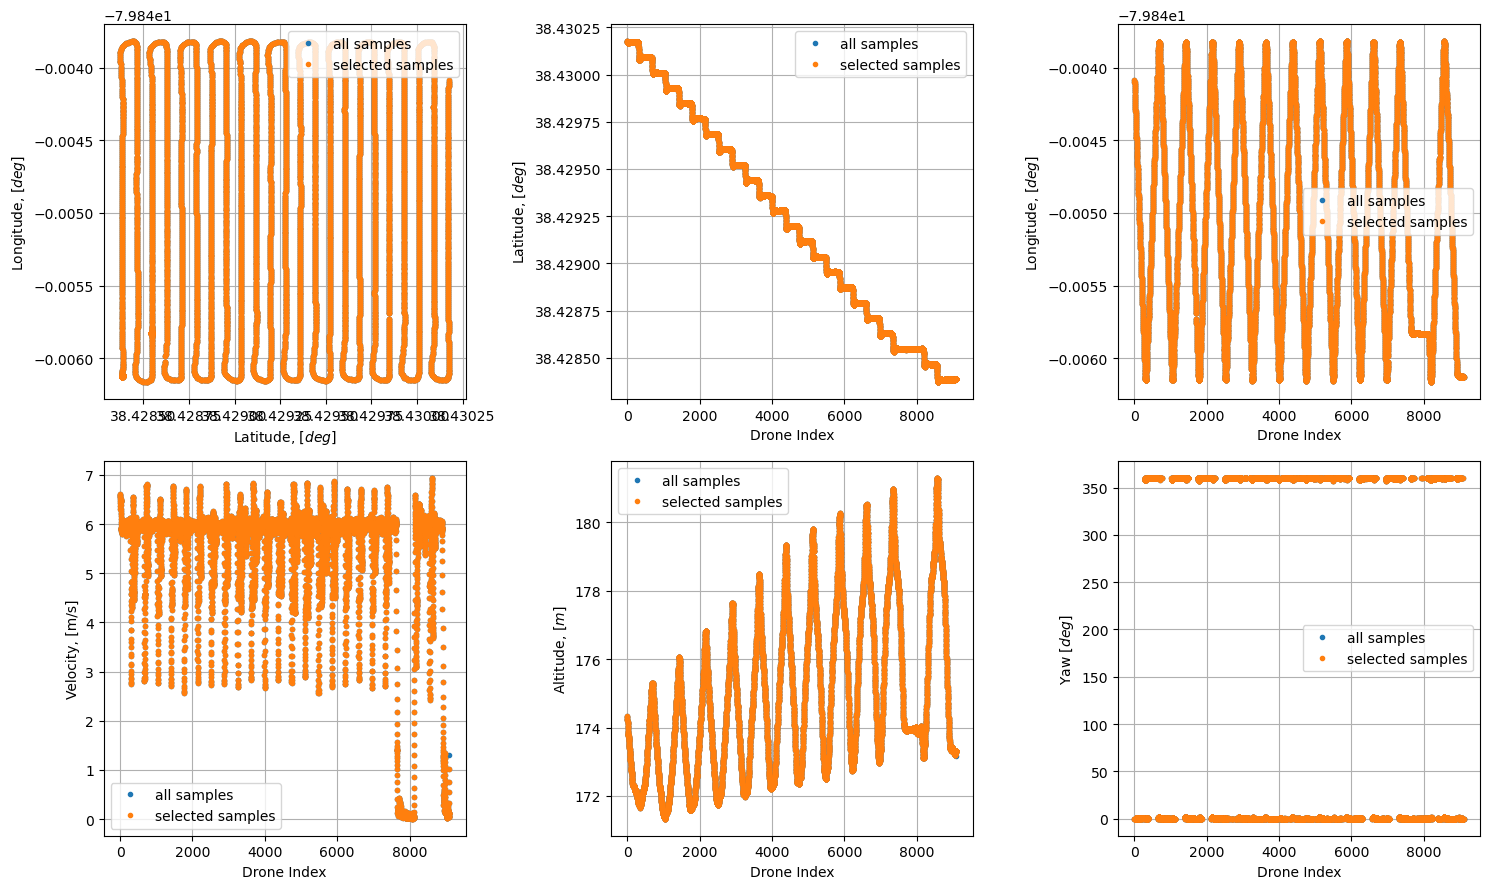

In [3]:
# Flight 1: 'FLY533.csv' 
dronedir='/hirax/all_drone_data/datcon_csv/'
f533drone=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite,tlb=dtlb,tub=dtub)
pu.Plot_Drone_Coordinates(f533drone)

In [4]:
datadir='/hirax/GBO_Aug_2021/TONE_ACQ/20210826T182904Z_yale_drone/corr/20210826T182915Z/'
gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/20210826T182904Z_yale_drone_yale_digitalgain/'
f533corr=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,site_class=gbosite,crossmap=[])

Initializing Correlator Class using:
  --> /hirax/GBO_Aug_2021/TONE_ACQ/20210826T182904Z_yale_drone/corr/20210826T182915Z/
  --> Arrays initialized with shape (124, 256, 1024, 16)
Assigning array values by reading in data files:
  --> Loading File: 0123/0123
  --> Finished. Reshaping arrays.


In [5]:
f533concat=concat.CONCAT(CORRDATCLASS=f533corr,DRONEDATCLASS=f533drone,\
                        config_directory="/hirax/GBO_Analysis_Outputs/tynd/concat_config_files/",\
                        output_directory="/hirax/GBO_Analysis_Outputs/tynd/",\
                        load_yaml=False,traceback=True,save_traceback=True)

Initializing CONCAT CLASS with active traceback using:
  --> /hirax/GBO_Aug_2021/TONE_ACQ/20210826T182904Z_yale_drone/corr/20210826T182915Z/
  --> FLY533.csv
Creating directory for saving traceback and analysis outputs:
  --> /hirax/GBO_Analysis_Outputs/tynd/FLY533_20210826T182904Z_ver_20231010T142152/
Concat initialized without previous config file...
Interpolating drone coordinates for each correlator timestamp:
  --> correlator timestamp axis contains 21755 elements
  --> drone timestamp axis contains 9100 elements


/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:230: RuntimeWarning: divide by zero encountered in divide
  normminsubdata=minsubdata/np.percentile(minsubdata,minmaxpercents[1])
/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:230: RuntimeWarning: invalid value encountered in divide
  normminsubdata=minsubdata/np.percentile(minsubdata,minmaxpercents[1])
/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:247: RuntimeWarning: All-NaN slice encountered
  maxPrind=np.where(Pr_arr[i,:]==np.nanmax(Pr_arr[i,:]))[0][0]


Maximum Pearson_R Correlations between data and square wave function:
  --> t_indices = [184. 187. 157. 188. 187. 187. 157. 187. 187. 187. 187. 187. 187.  nan
 168. 188.]
  --> t_deltas = [-0.216 -0.213 -0.243 -0.212 -0.213 -0.213 -0.243 -0.213 -0.213 -0.213
 -0.213 -0.213 -0.213    nan -0.232 -0.212]
Selecting square wave function time offset:
  --> t_delta_pulse = -0.2130000000
Finding relevant pulsing indices and checking for overlaps:
  --> on/off ind intersection: []
  --> on/span ind intersection: []
  --> off/span ind intersection: []
Calculating background spectra from indices where the noise source is off.


/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:334: RuntimeWarning: Mean of empty slice
  self.V_bg[k,:,:]=np.nanmean(self.V[t_window,:,:],axis=0)


  --> Background subtraction completed using window_size = 5
Synchronizing data from correlator and drone:
  --> Previous t_delta_dji not found
  --> Calculating via 2DGauss fitting routine:


/home/tyndall/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/tyndall/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


Applying a time correction of -0.03 seconds using Channel 1 fits.
  --> Variable synchronation successful, generating output plots:
  --> Saving output plot.


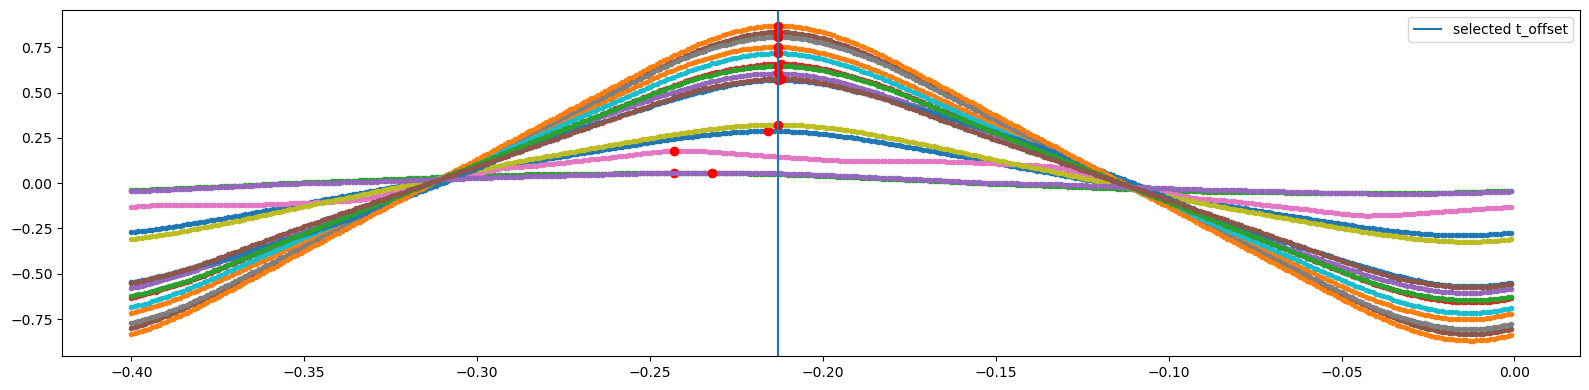

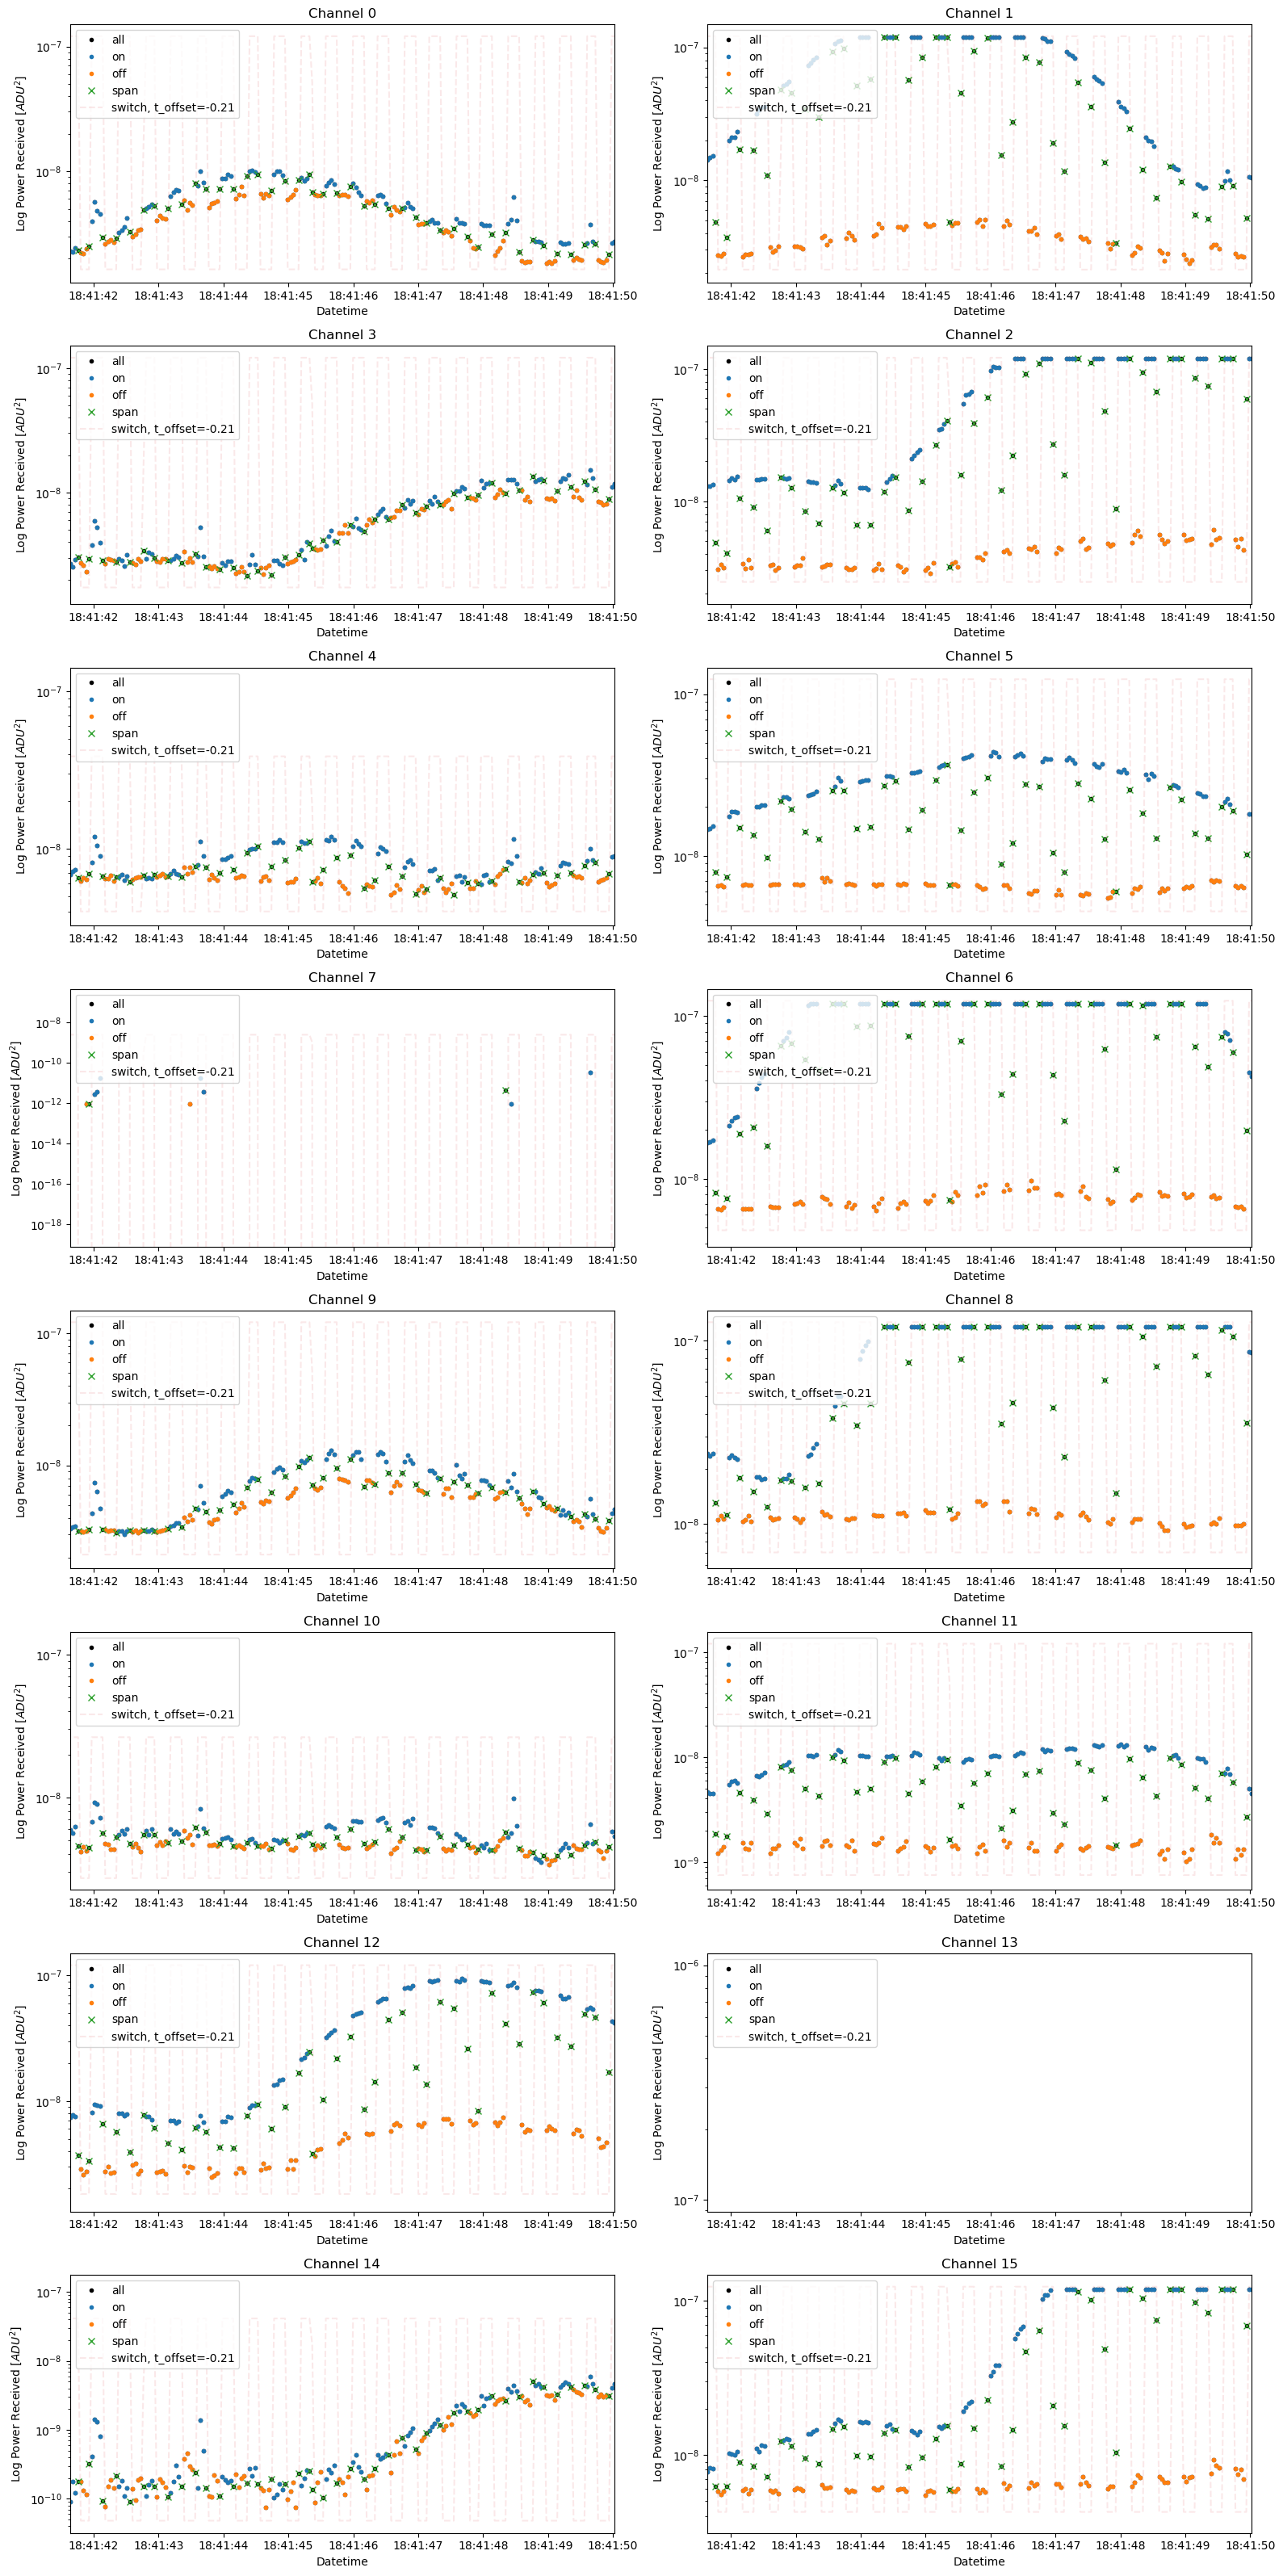

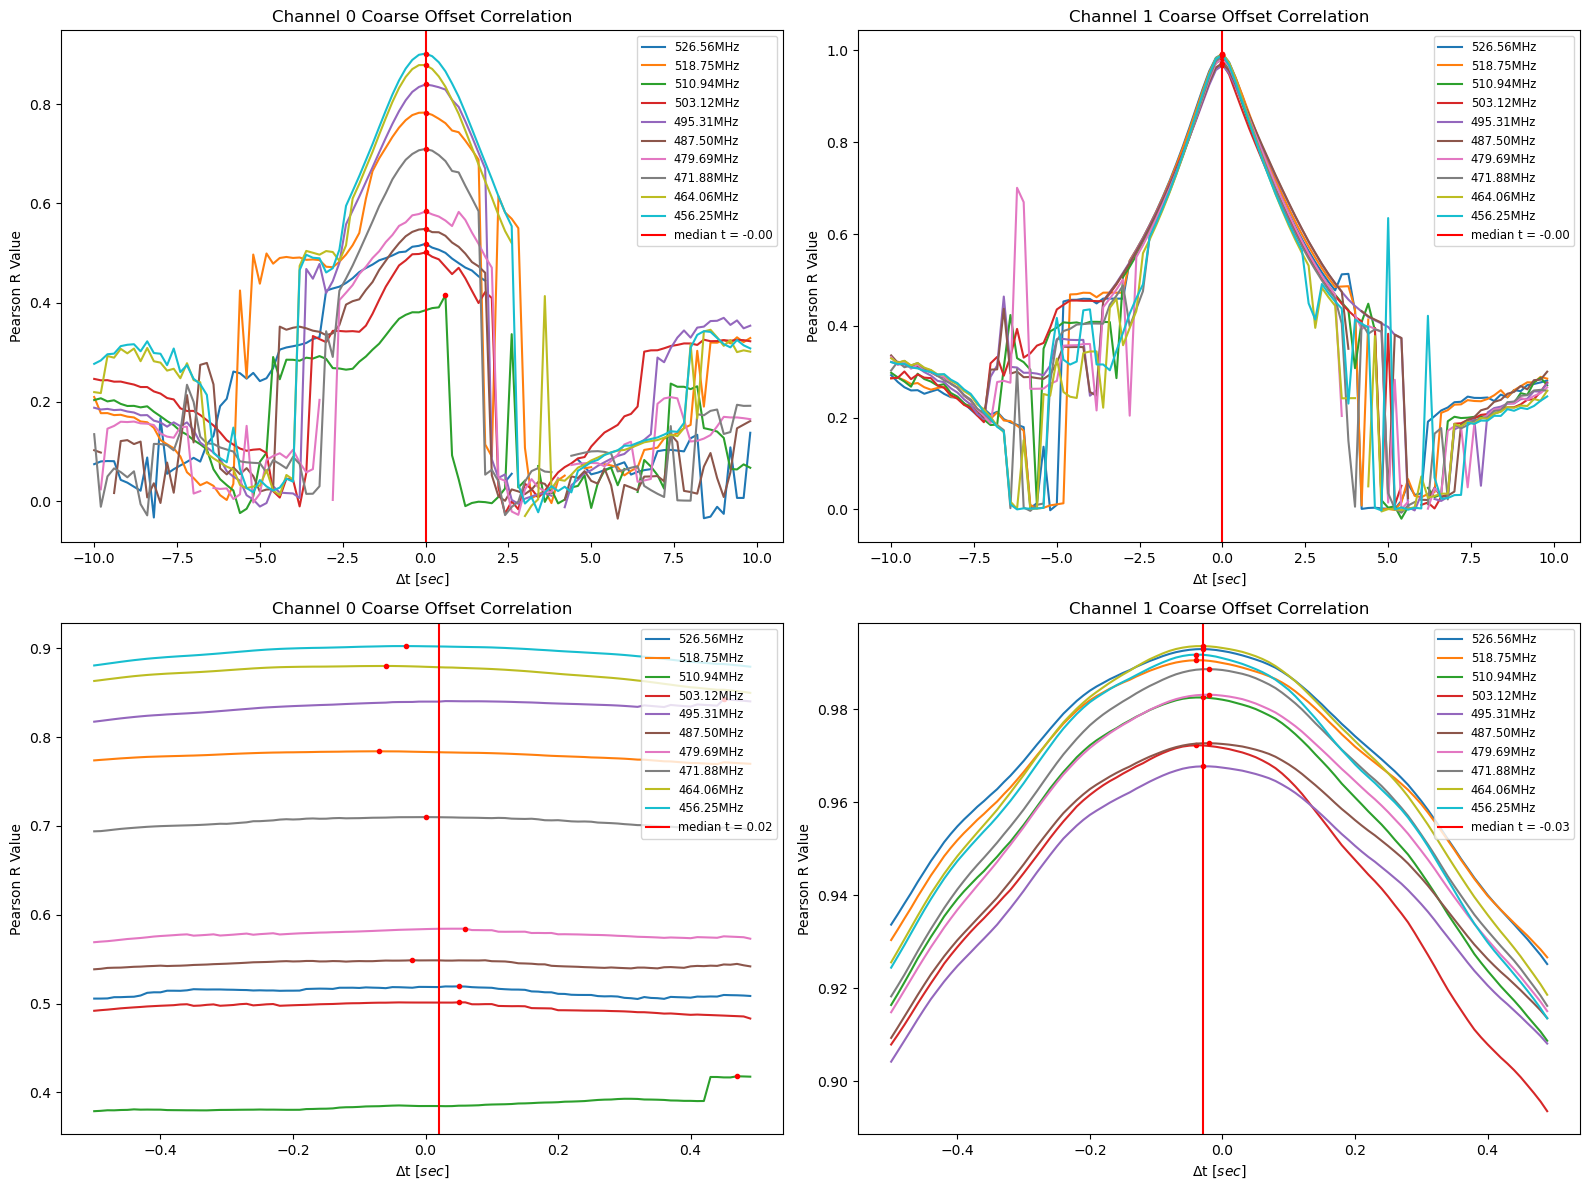

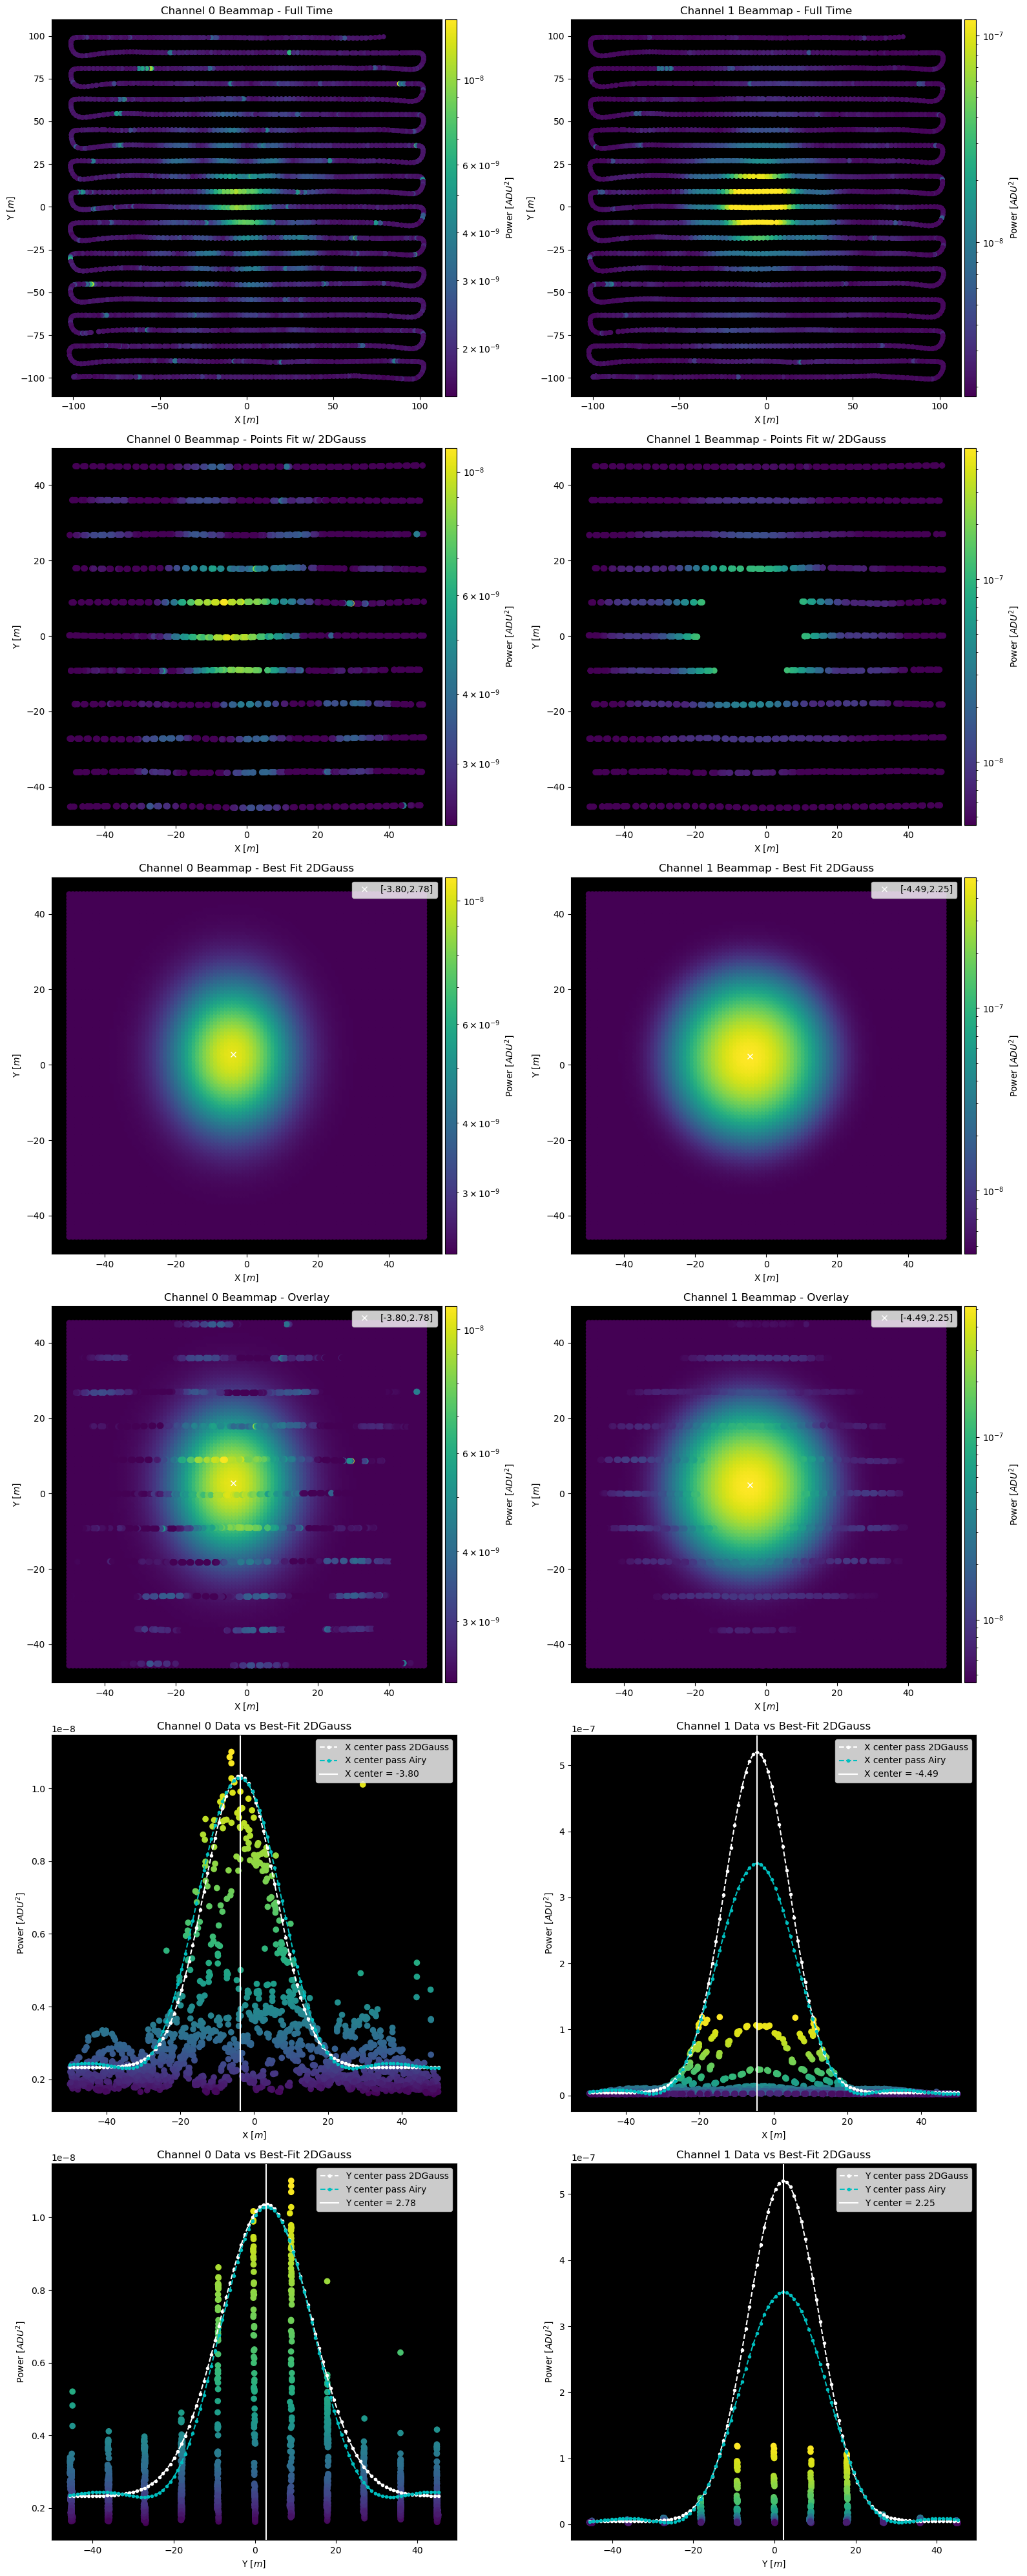

In [6]:
f533concat.Extract_Source_Pulses(Period=400000,Dutycycle=200000,t_bounds=[17800,18000],f_ind=900,minmaxpercents=[10.0,99.0])

f533concat.Perform_Background_Subtraction(window_size=5)
f533concat.Synchronization_Function(inputcorr=f533corr,inputdrone=f533drone,freqs=np.arange(700,900,20),\
                                    FMB_coordbounds=[50.0,50.0,100.0],FMB_ampbound=0.999)
# f533concat.Main_Beam_Fitting(fit_param_directory="/hirax/GBO_Analysis_Outputs/tynd/main_beam_fits/",Vargs='bgsub',coordbounds=[20,20,15])
# # FFNSconcat.Export_yaml()

# #export pickle for reduced class data for beammap function (include_cross_data=True will save V_cross_bgsub):
# # thingy = rc.Smallify(concatclass=FFNSconcat,pickle_directory="/home/tyndall/Desktop/20230519_WLC_NF2FF_Flights/products/pickles/",include_cross_data=True)
# # print(thingy.tmppath)
# # with open(thingy.tmppath, 'wb') as outp:
# #     pickle.dump(thingy, outp, pickle.HIGHEST_PROTOCOL)
# # print('DONE')

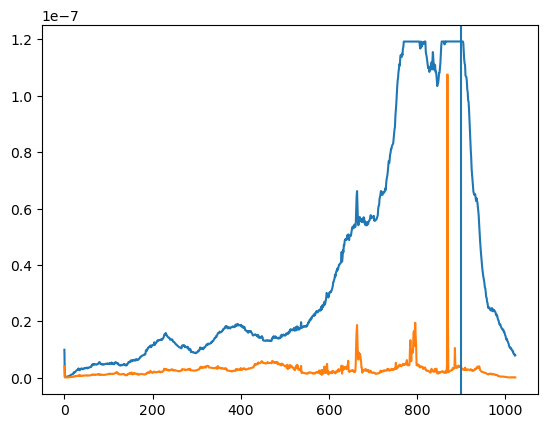

In [7]:
plot(f533concat.V[17020,:,1])
plot(f533concat.V[17022,:,1])
axvline(900)

(0.0, 1.5)

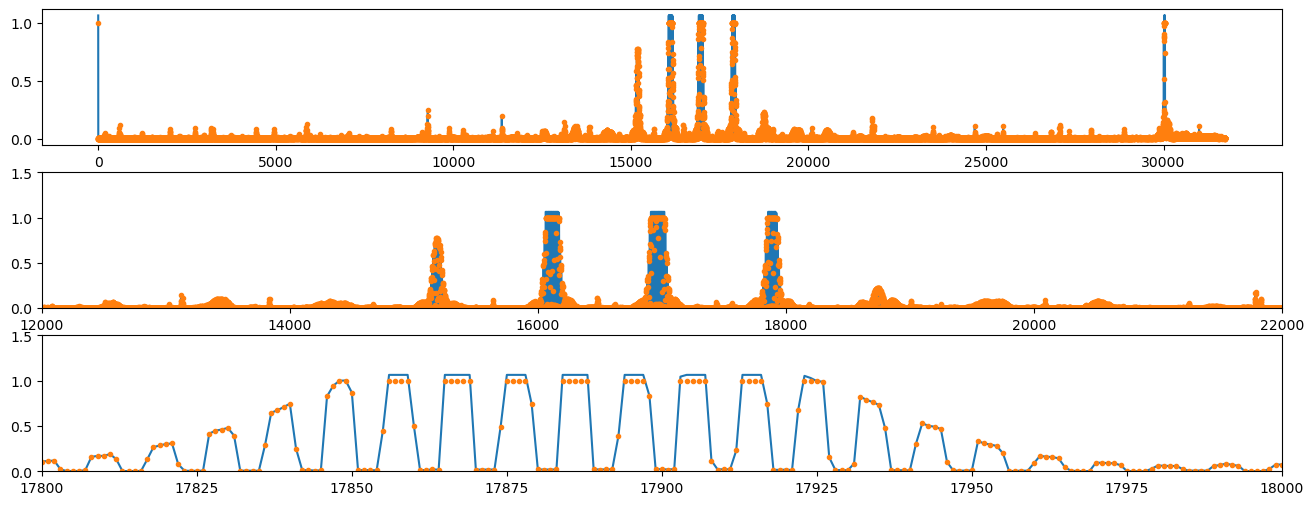

In [8]:
fig,[ax1,ax2,ax3]=subplots(nrows=3,ncols=1,figsize=(16,6))
find=900
chind=1
subdat=f533concat.V[:,find,chind]-np.percentile(f533concat.V[:,find,chind],10.0)
normdat=subdat/np.percentile(subdat,99.5)
clipdat=normdat.clip(0,1)
ax1.plot(normdat)
ax1.plot(clipdat,'.')
ax2.plot(normdat)
ax2.plot(clipdat,'.')
ax2.set_xlim(12000,22000)
ax2.set_ylim(0,1.5)
ax3.plot(normdat)
ax3.plot(clipdat,'.')
ax3.set_xlim(17800,18000)
ax3.set_ylim(0,1.5)

In [9]:
f533concat.drone_xyz_per_dish_interp

array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]

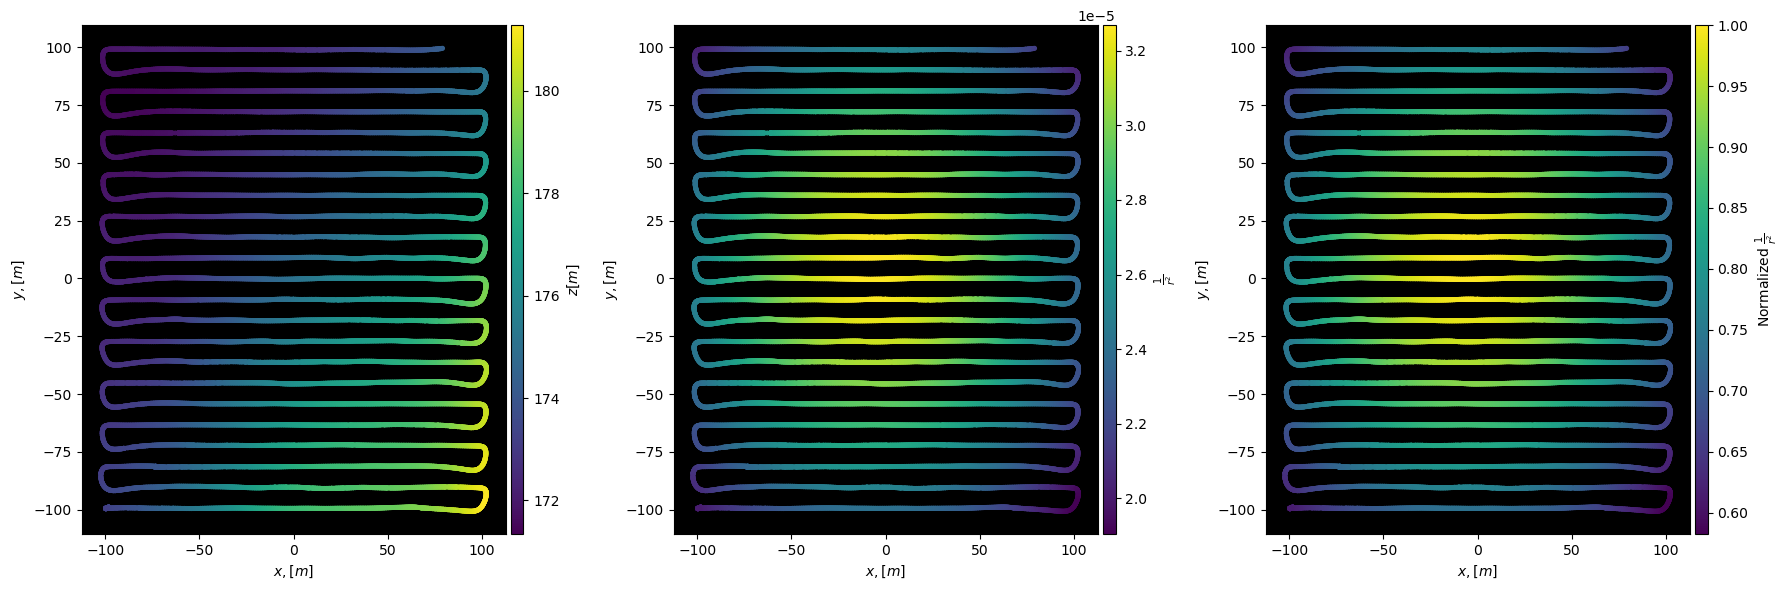

In [10]:
fig,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(18,6))
tlb,tub=0,-1
x=f533concat.drone_xyz_per_dish_interp[0,:,0]
y=f533concat.drone_xyz_per_dish_interp[0,:,1]
z=f533concat.drone_xyz_per_dish_interp[0,:,2]
r=((x**2.0+y**2.0+z**2.0)**0.5)
r0=np.nanmin(r)
im1=ax1.scatter(x,y,c=z,s=7)
im2=ax2.scatter(x,y,c=((x**2+y**2+z**2)**-1),s=7)
im3=ax3.scatter(x,y,c=((x**2+y**2+z**2)**-1)/np.nanmax(((x**2+y**2+z**2)**-1.0)),s=7)

#im3=ax3.scatter(x,y,c=((f533concat.drone_rpt_r_per_dish_interp[1,tlb:tub,0])**-2)/np.nanmax(((f533concat.drone_rpt_r_per_dish_interp[1,tlb:tub,0])**-2)),s=7)

images=[im1,im2,im3]
cbarlabels=["$z [m]$",r"$\frac{1}{r^{2}}$",r"Normalized $\frac{1}{r^{2}}$"]

for j,ax in enumerate([ax1,ax2,ax3]):
    ax.set_facecolor('k')
    ax.set_xlabel('$x,[m]$')
    ax.set_ylabel('$y, [m]$')
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="3%", pad=0.05)
    cbar=fig.colorbar(images[j],cax=cax)
    cbar.set_label(cbarlabels[j])
tight_layout()


<Figure size 640x480 with 0 Axes>

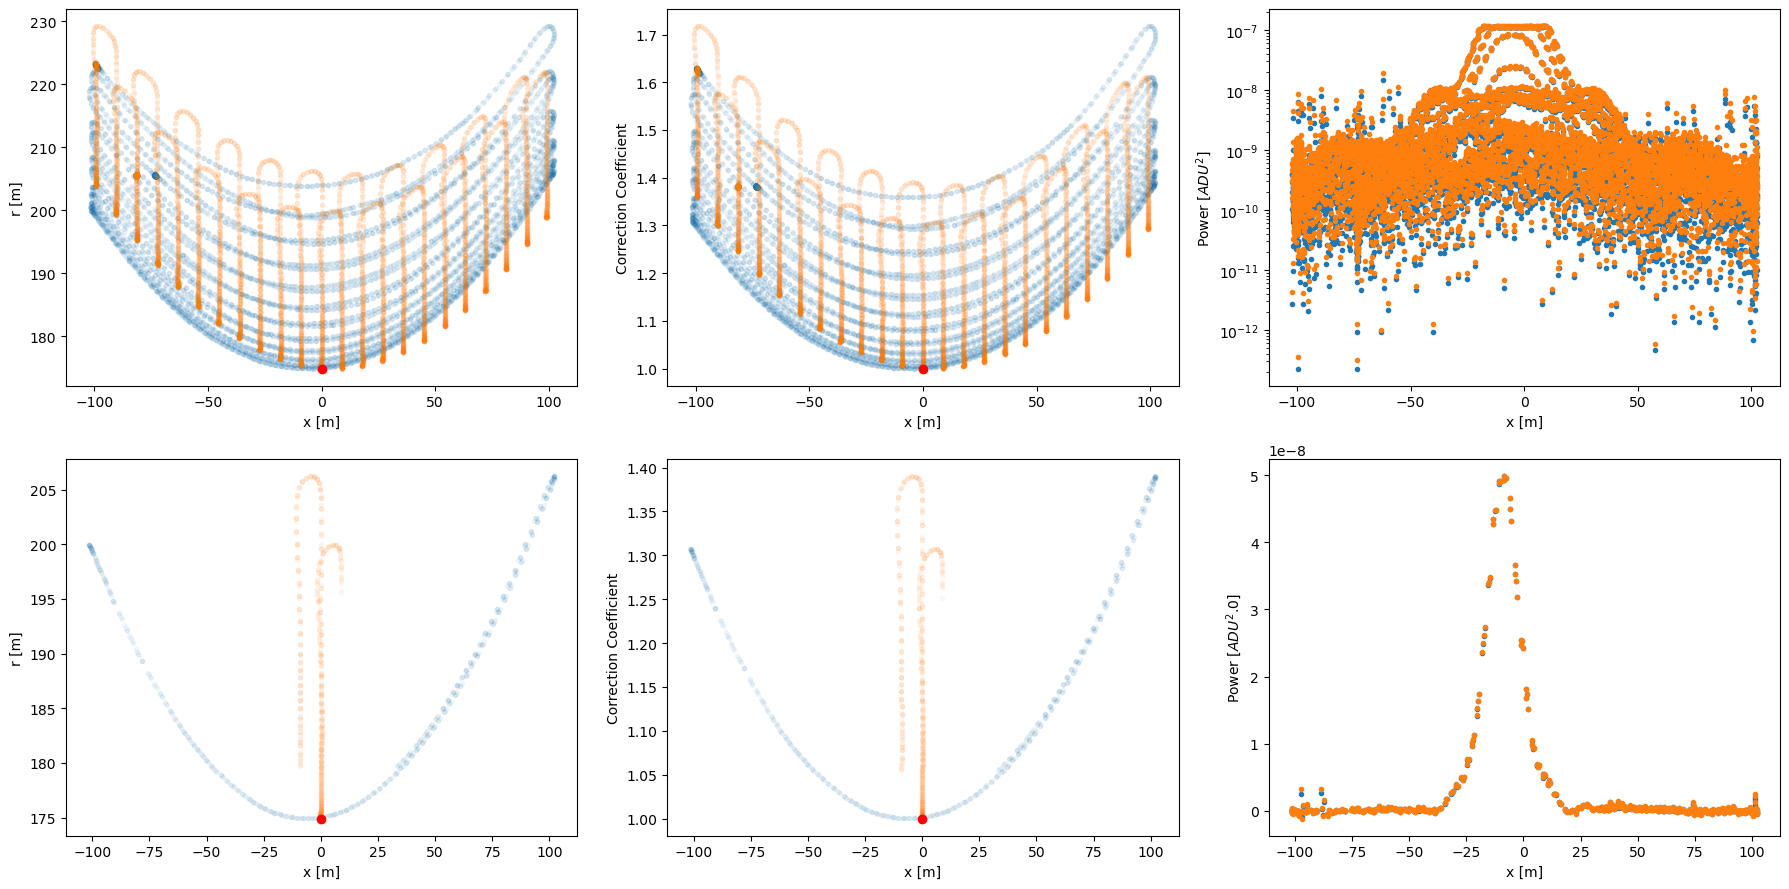

<Figure size 640x480 with 0 Axes>

In [11]:
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]]=subplots(nrows=2,ncols=3,figsize=(18,9))
tinds=f533concat.inds_on[6500:7000]
ax1.plot(x[f533concat.inds_on],r[f533concat.inds_on],'.',alpha=0.05)
ax1.plot(y[f533concat.inds_on],r[f533concat.inds_on],'.',alpha=0.05)
ax1.plot(0.0,np.nanmin(r),'ro')
ax2.plot(x[f533concat.inds_on],(r[f533concat.inds_on]/r0)**2.0,'.',alpha=0.05)
ax2.plot(y[f533concat.inds_on],(r[f533concat.inds_on]/r0)**2.0,'.',alpha=0.05)
ax2.plot(0.0,np.nanmin((r/r0)**2.0),'ro')
ax3.semilogy(x[f533concat.inds_on],(f533concat.V_bgsub[:,900,1])[f533concat.inds_on],'.')
ax3.semilogy(x[f533concat.inds_on],(((r/r0)**2.0)*f533concat.V_bgsub[:,900,1])[f533concat.inds_on],'.')
ax4.plot(x[tinds],r[tinds],'.',alpha=0.05)
ax4.plot(y[tinds],r[tinds],'.',alpha=0.05)
ax4.plot(0.0,np.nanmin(r),'ro')
ax5.plot(x[tinds],(r[tinds]/r0)**2.0,'.',alpha=0.05)
ax5.plot(y[tinds],(r[tinds]/r0)**2.0,'.',alpha=0.05)
ax5.plot(0.0,np.nanmin((r/r0)**2.0),'ro')
#ax6.plot(x[tinds],(f533concat.V_bgsub[:,900,1])[tinds],'.')
#ax6.plot(x[tinds],(((r/r0)**2.0)*f533concat.V_bgsub[:,900,1])[tinds],'.')
ax6.plot(x[tinds],(f533concat.V_bgsub[:,340,0])[tinds],'.')
ax6.plot(x[tinds],(((r/r0)**2.0)*f533concat.V_bgsub[:,340,0])[tinds],'.')
ylabels=['r [m]','Correction Coefficient','Power [$ADU^2$]','r [m]','Correction Coefficient','Power [$ADU^2.0$]']
for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
    ax.set_xlabel('x [m]')
    ax.set_ylabel(ylabels[i])
tight_layout()
figure()


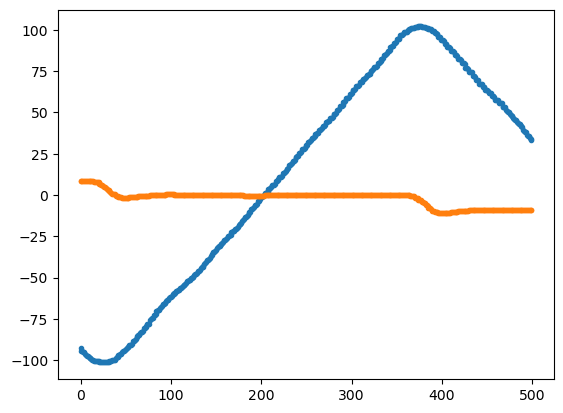

In [12]:
plot(x[tinds],'.')
plot(y[tinds],'.')

In [176]:
(int(f533concat.V.shape[0]),1,int(f533concat.V.shape[2]))

(31744, 1, 16)

  --> Applying correction to V_bgsub using concat.Distance_Compensation() Function:
    --> Complete.


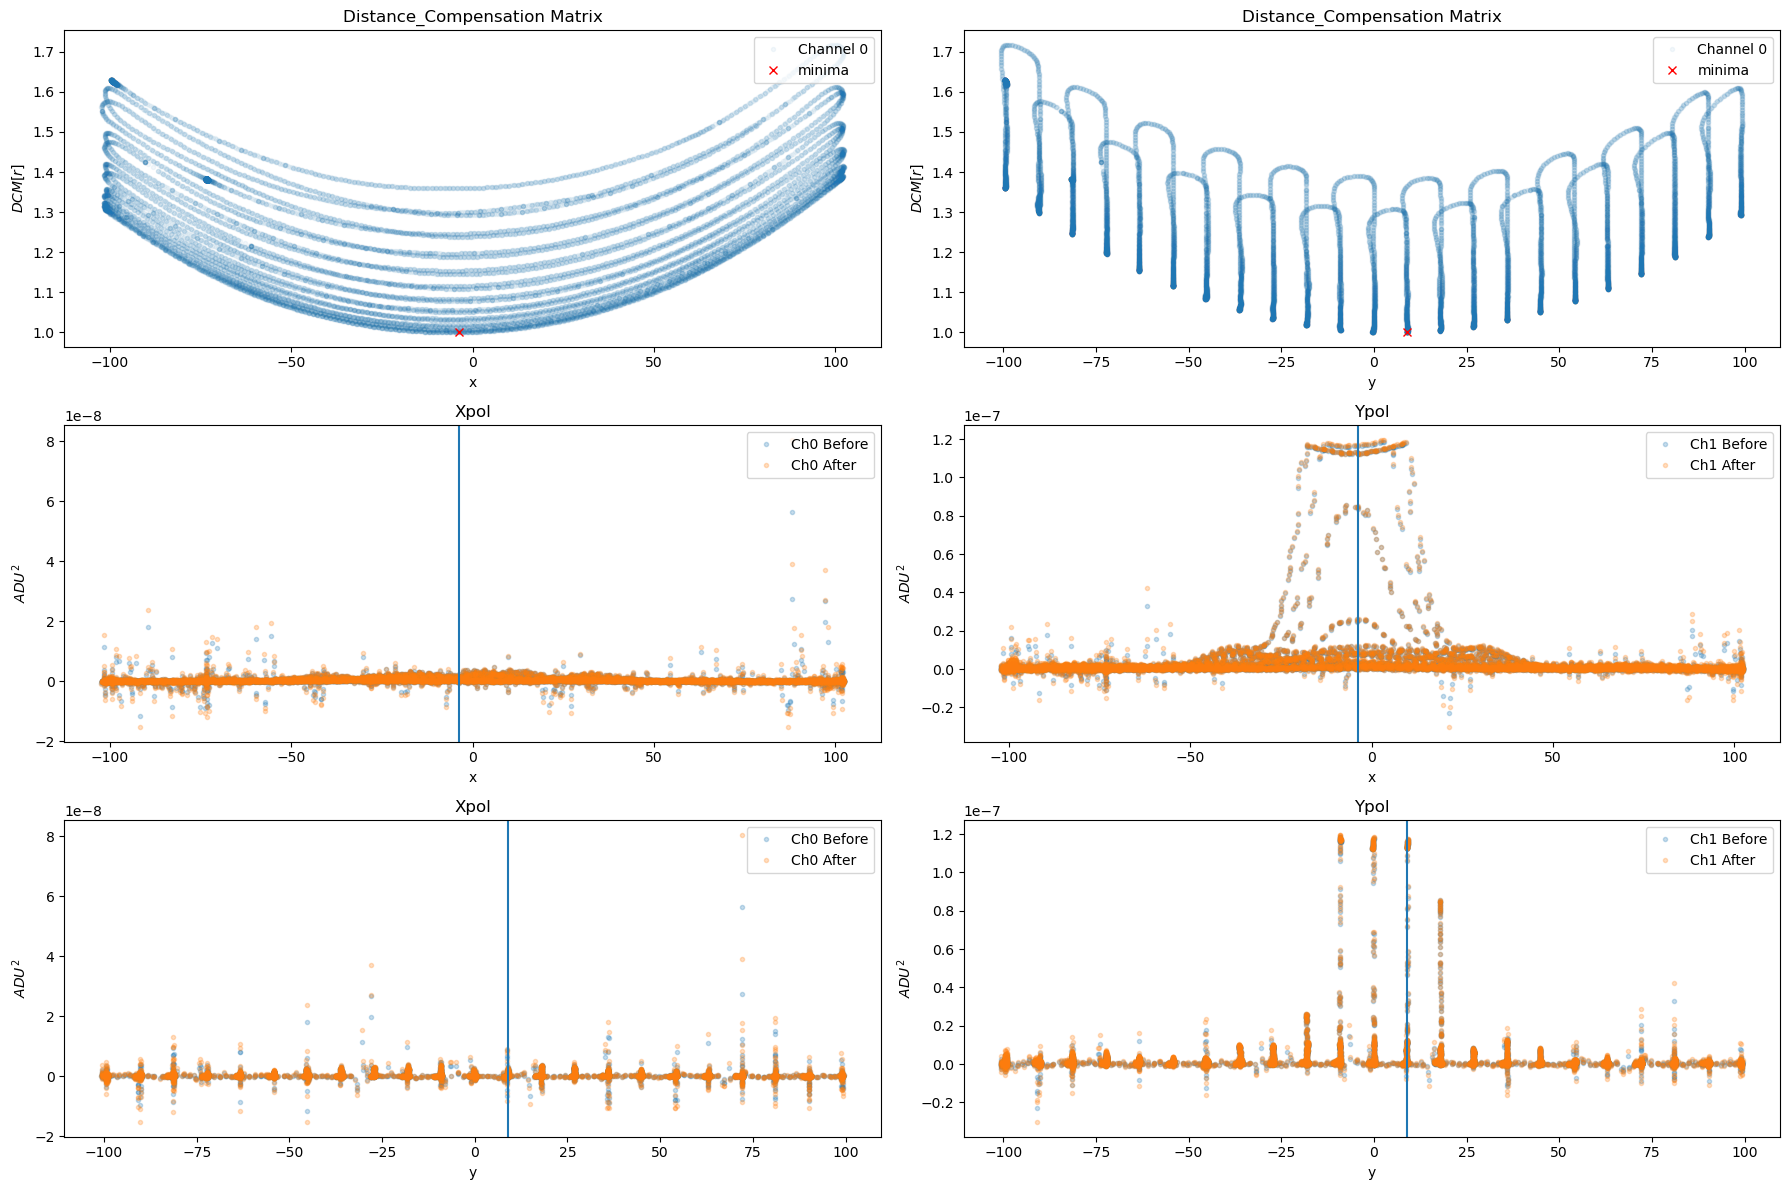

In [212]:
def Distance_Compensation(concatclass,plot_channels=[0]):
    if hasattr(concatclass,'V_bgsub'):
        if hasattr(concatclass,'drone_xyz_per_dish_interp'):
            if concatclass.traceback==True:
                print('  --> Applying correction to V_bgsub using concat.Distance_Compensation() Function:')
    r2coeffmatrix=np.NaN*np.ones((int(concatclass.V.shape[0]),1,int(concatclass.V.shape[2])))
    rmin=np.zeros(16).astype(int)
    r0=np.zeros(16)
    for i in range(concatclass.n_channels):
        rdist=np.abs(np.sqrt(((concatclass.drone_xyz_per_dish_interp[i,:,0]**2.0)+(concatclass.drone_xyz_per_dish_interp[i,:,1]**2.0)+(concatclass.drone_xyz_per_dish_interp[i,:,2]**2.0))))
        rmin[i]=int(np.where(rdist==np.nanmin(rdist))[0][0])
        r0[i]=rdist[rmin[i]]
        r2coeffmatrix[:,:,i]=((rdist**2.0)/(r0[i]**2.0)).reshape((len(rdist),1))
    ## Multiply V_bgsub by the distance compensation matrix 
    compensated_V_bgsub=r2coeffmatrix*concatclass.V_bgsub
    ## Plot with the traceback:
    if concatclass.traceback==True:
        fig,[[ax1,ax2],[ax3,ax4],[ax5,ax6]]=subplots(nrows=3,ncols=2,figsize=(18,12))
        for k in plot_channels:
            ## Grab minima for plotting
            mininds[k,:]=np.where(r2coeffmatrix[:,0,k]==np.nanmin(r2coeffmatrix[:,0,k]))[0][0]
            minvals[k,:]=concatclass.drone_xyz_LC_interp[mininds[k],0]
            ## Plot r2coeffmatrix vs position
            ax1.plot(concatclass.drone_xyz_per_dish_interp[k,:,0],r2coeffmatrix[:,0,k],'.',alpha=0.05,label='Channel {}'.format(k))
            ax1.plot(concatclass.drone_xyz_per_dish_interp[k,mininds[k],0],r2coeffmatrix[mininds[k],0,k],'rx')
            ax2.plot(concatclass.drone_xyz_per_dish_interp[k,:,1],r2coeffmatrix[:,0,k],'.',alpha=0.05,label='Channel {}'.format(k))
            ax2.plot(concatclass.drone_xyz_per_dish_interp[k,mininds[k],1],r2coeffmatrix[mininds[k],0,k],'rx')         
            ## Plot before/after spectra vs x
            ax3.plot(concatclass.drone_xyz_per_dish_interp[k,:,0][concatclass.inds_on],concatclass.V_bgsub[:,900,k][concatclass.inds_on],'.',alpha=0.25,label='Ch{} Before'.format(k))
            ax3.plot(concatclass.drone_xyz_per_dish_interp[k,:,0][concatclass.inds_on],compensated_V_bgsub[:,900,k][concatclass.inds_on],'.',alpha=0.25,label='Ch{} After'.format(k))
            ax3.axvline(concatclass.drone_xyz_per_dish_interp[k,mininds[k],0])
            ax4.plot(concatclass.drone_xyz_per_dish_interp[k,:,0][concatclass.inds_on],concatclass.V_bgsub[:,900,k+1][concatclass.inds_on],'.',alpha=0.25,label='Ch{} Before'.format(k+1))
            ax4.plot(concatclass.drone_xyz_per_dish_interp[k,:,0][concatclass.inds_on],compensated_V_bgsub[:,900,k+1][concatclass.inds_on],'.',alpha=0.25,label='Ch{} After'.format(k+1))
            ax4.axvline(concatclass.drone_xyz_per_dish_interp[k,mininds[k],0])
            ## Plot before/after spectra vs y
            ax5.plot(concatclass.drone_xyz_per_dish_interp[k,:,1][concatclass.inds_on],concatclass.V_bgsub[:,900,k][concatclass.inds_on],'.',alpha=0.25,label='Ch{} Before'.format(k))
            ax5.plot(concatclass.drone_xyz_per_dish_interp[k,:,1][concatclass.inds_on],compensated_V_bgsub[:,900,k][concatclass.inds_on],'.',alpha=0.25,label='Ch{} After'.format(k))
            ax5.axvline(concatclass.drone_xyz_per_dish_interp[k,mininds[k],1])
            ax6.plot(concatclass.drone_xyz_per_dish_interp[k,:,1][concatclass.inds_on],concatclass.V_bgsub[:,900,k+1][concatclass.inds_on],'.',alpha=0.25,label='Ch{} Before'.format(k+1))
            ax6.plot(concatclass.drone_xyz_per_dish_interp[k,:,1][concatclass.inds_on],compensated_V_bgsub[:,900,k+1][concatclass.inds_on],'.',alpha=0.25,label='Ch{} After'.format(k+1))
            ax6.axvline(concatclass.drone_xyz_per_dish_interp[k,mininds[k],1])
        for ax in [ax1,ax2]:
            ax.plot([],[],'rx',label='minima')
        titles=['Distance_Compensation Matrix','Distance_Compensation Matrix','Xpol','Ypol','Xpol','Ypol']
        xlabels=['x','y','x','x','y','y']
        ylabels=['$DCM[r]$','$DCM[r]$','$ADU^2$','$ADU^2$','$ADU^2$','$ADU^2$']
        for ai,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
            ax.set_title(titles[ai])
            ax.set_xlabel(xlabels[ai])
            ax.set_ylabel(ylabels[ai])
            ax.legend(loc=1)
        tight_layout()
        #concatclass.V_bgsub=compensated_V_bgsub
        print('    --> Complete.')
    
dd=Distance_Compensation(f533concat)

    
    

In [ ]:
stop

## Formatting for the real code distribution:

    def Distance_Compensation(self,f_ind=900,plot_channels=[0]):
        if hasattr(self,'V_bgsub'):
            if hasattr(self,'drone_xyz_per_dish_interp'):
                if self.traceback==True:
                    print('Applying correction to V_bgsub using concat.Distance_Compensation() Function:')
        r2coeffmatrix=np.NaN*np.ones((int(self.V.shape[0]),1,int(self.V.shape[2])))
        rmin=np.zeros(self.n_channels).astype(int)
        r0=np.zeros(self.n_channels)
        for i in range(self.n_channels):
            rdist=np.abs(np.sqrt(((self.drone_xyz_per_dish_interp[i,:,0]**2.0)+(self.drone_xyz_per_dish_interp[i,:,1]**2.0)+(self.drone_xyz_per_dish_interp[i,:,2]**2.0))))
            rmin[i]=int(np.where(rdist==np.nanmin(rdist))[0][0])
            r0[i]=rdist[rmin[i]]
            r2coeffmatrix[:,:,i]=((rdist**2.0)/(r0[i]**2.0)).reshape((len(rdist),1))
        ## Multiply V_bgsub by the distance compensation matrix 
        compensated_V_bgsub=r2coeffmatrix*self.V_bgsub
        ## Plot with the traceback:
        if self.traceback==True:
            fig,[[ax1,ax2],[ax3,ax4],[ax5,ax6]]=subplots(nrows=3,ncols=2,figsize=(18,12))
            mininds=np.zeros(self.n_channels).astype(int)
            for k in plot_channels:
                ## Grab minima for plotting
                mininds[k]=np.where(r2coeffmatrix[:,0,k]==np.nanmin(r2coeffmatrix[:,0,k]))[0][0]
                ## Plot r2coeffmatrix vs position
                ax1.plot(self.drone_xyz_per_dish_interp[k,:,0],r2coeffmatrix[:,0,k],'.',alpha=0.05,label='Channel {}'.format(k))
                ax1.plot(self.drone_xyz_per_dish_interp[k,mininds[k],0],r2coeffmatrix[mininds[k],0,k],'rx')
                ax2.plot(self.drone_xyz_per_dish_interp[k,:,1],r2coeffmatrix[:,0,k],'.',alpha=0.05,label='Channel {}'.format(k))
                ax2.plot(self.drone_xyz_per_dish_interp[k,mininds[k],1],r2coeffmatrix[mininds[k],0,k],'rx')         
                ## Plot before/after spectra vs x
                ax3.plot(self.drone_xyz_per_dish_interp[k,:,0][self.inds_on],self.V_bgsub[:,f_ind,k][self.inds_on],'.',alpha=0.25,label='Ch{} Before'.format(k))
                ax3.plot(self.drone_xyz_per_dish_interp[k,:,0][self.inds_on],compensated_V_bgsub[:,f_ind,k][self.inds_on],'.',alpha=0.25,label='Ch{} After'.format(k))
                ax3.axvline(self.drone_xyz_per_dish_interp[k,mininds[k],0])
                ax4.plot(self.drone_xyz_per_dish_interp[k,:,0][self.inds_on],self.V_bgsub[:,f_ind,k+1][self.inds_on],'.',alpha=0.25,label='Ch{} Before'.format(k+1))
                ax4.plot(self.drone_xyz_per_dish_interp[k,:,0][self.inds_on],compensated_V_bgsub[:,f_ind,k+1][self.inds_on],'.',alpha=0.25,label='Ch{} After'.format(k+1))
                ax4.axvline(self.drone_xyz_per_dish_interp[k,mininds[k],0])
                ## Plot before/after spectra vs y
                ax5.plot(self.drone_xyz_per_dish_interp[k,:,1][self.inds_on],self.V_bgsub[:,f_ind,k][self.inds_on],'.',alpha=0.25,label='Ch{} Before'.format(k))
                ax5.plot(self.drone_xyz_per_dish_interp[k,:,1][self.inds_on],compensated_V_bgsub[:,f_ind,k][self.inds_on],'.',alpha=0.25,label='Ch{} After'.format(k))
                ax5.axvline(self.drone_xyz_per_dish_interp[k,mininds[k],1])
                ax6.plot(self.drone_xyz_per_dish_interp[k,:,1][self.inds_on],self.V_bgsub[:,f_ind,k+1][self.inds_on],'.',alpha=0.25,label='Ch{} Before'.format(k+1))
                ax6.plot(self.drone_xyz_per_dish_interp[k,:,1][self.inds_on],compensated_V_bgsub[:,f_ind,k+1][self.inds_on],'.',alpha=0.25,label='Ch{} After'.format(k+1))
                ax6.axvline(self.drone_xyz_per_dish_interp[k,mininds[k],1])
            for ax in [ax1,ax2]:
                ax.plot([],[],'rx',label='minima')
            titles=['Distance_Compensation Matrix','Distance_Compensation Matrix','Xpol','Ypol','Xpol','Ypol']
            xlabels=['x','y','x','x','y','y']
            ylabels=['$DCM[r]$','$DCM[r]$','$ADU^2$','$ADU^2$','$ADU^2$','$ADU^2$']
            for ai,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
                ax.set_title(titles[ai])
                ax.set_xlabel(xlabels[ai])
                ax.set_ylabel(ylabels[ai])
                ax.legend(loc=1)
            tight_layout()
            ## Save figure?
            if self.save_traceback==True:
                print('  --> Saving output plot.')
                savefig(self.Output_Directory+self.Output_Prefix+"_Distance_Compensation_Verification.png")
            ## Redefine variable V_bgsub:
            print('  --> Complete.')
            del self.V_bgsub
            self.bgsub=compensated_V_bgsub
            
            

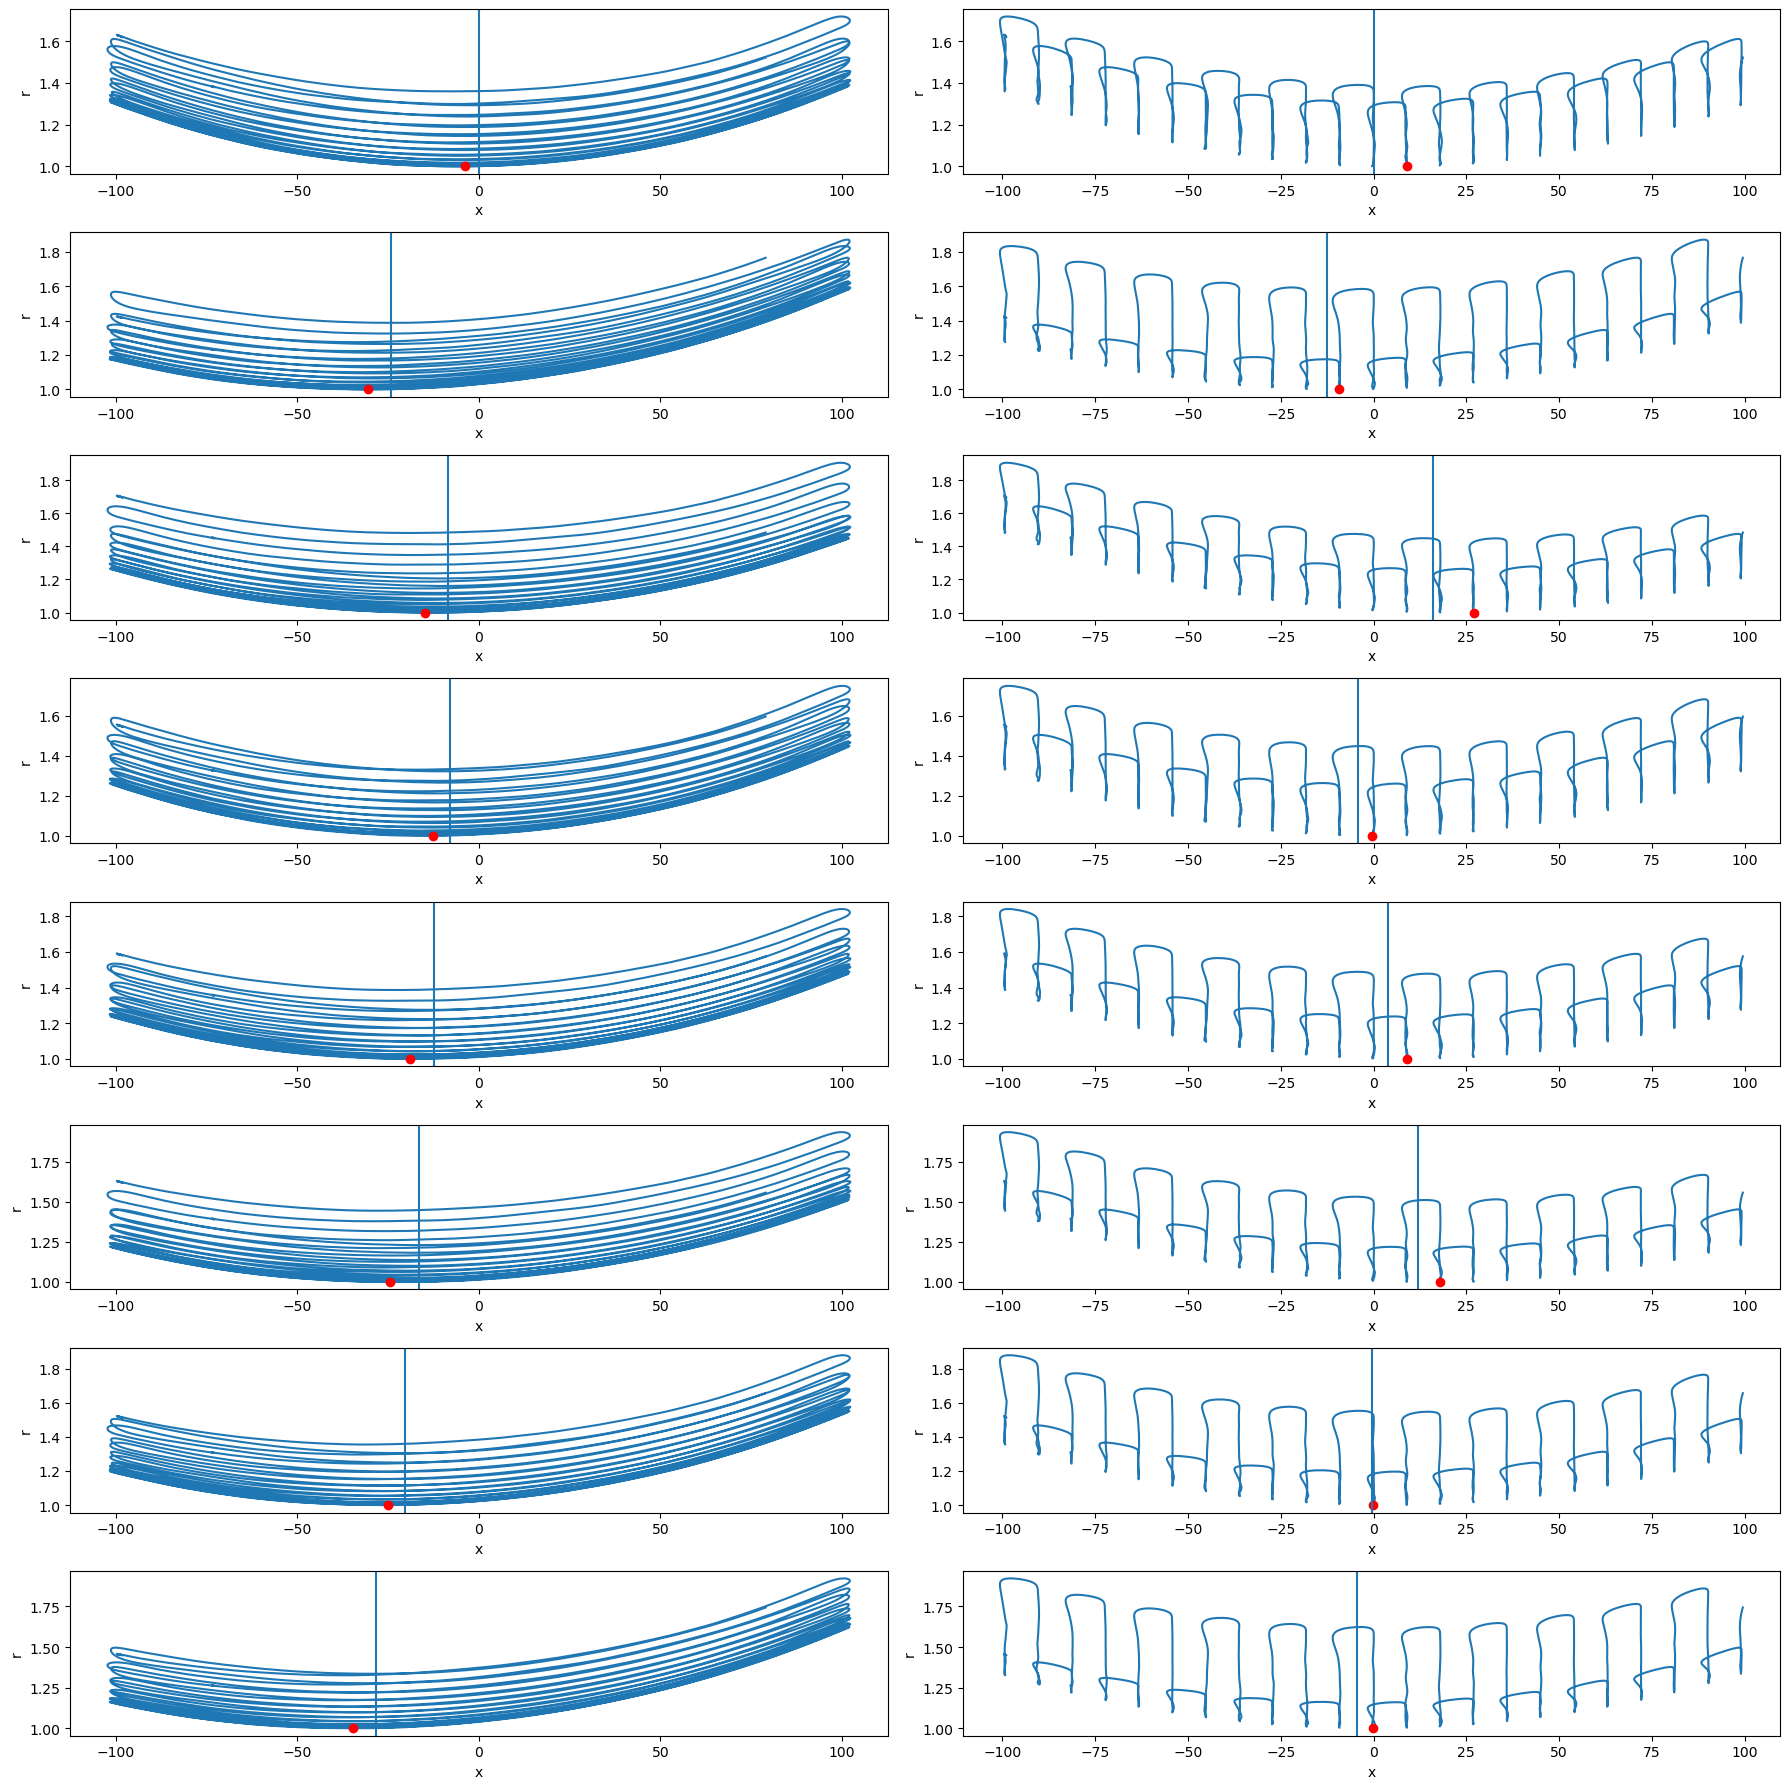

In [147]:
fig,axes=subplots(nrows=8,ncols=2,figsize=(18,18))
mininds=np.zeros((16,1)).astype(int)
minvals=np.NaN*np.ones((16,1))
for i,k in enumerate([0,2,4,6,8,10,12,14]):
    [ax1,ax2]=axes[i]
    mininds[k,:]=np.where(dd[:,0,k]==np.nanmin(dd[:,0,k]))[0][0]
    minvals[k,:]=f533concat.drone_xyz_LC_interp[mininds[k],0]
    ax1.plot(f533concat.drone_xyz_LC_interp[:,0],dd[:,0,k],label='{}'.format(k))
    ax1.plot(f533concat.drone_xyz_LC_interp[mininds[k],0],dd[mininds[k],0,k],'ro')
    ax1.axvline(f533concat.dish_coords[k,0])
    ax2.plot(f533concat.drone_xyz_LC_interp[:,1],dd[:,1,k],label='{}'.format(k))
    ax2.plot(f533concat.drone_xyz_LC_interp[mininds[k],1],dd[mininds[k],1,k],'ro')
    ax2.axvline(f533concat.dish_coords[k,1])
    ax1.set_xlabel('x')
    ax1.set_ylabel('r')
    ax2.set_xlabel('x')
    ax2.set_ylabel('r')
tight_layout()
# ax1.set_xlim(-50,50)
# ax2.set_xlim(-50,50)

In [99]:
dat_corr=dd*f533concat.V_bgsub

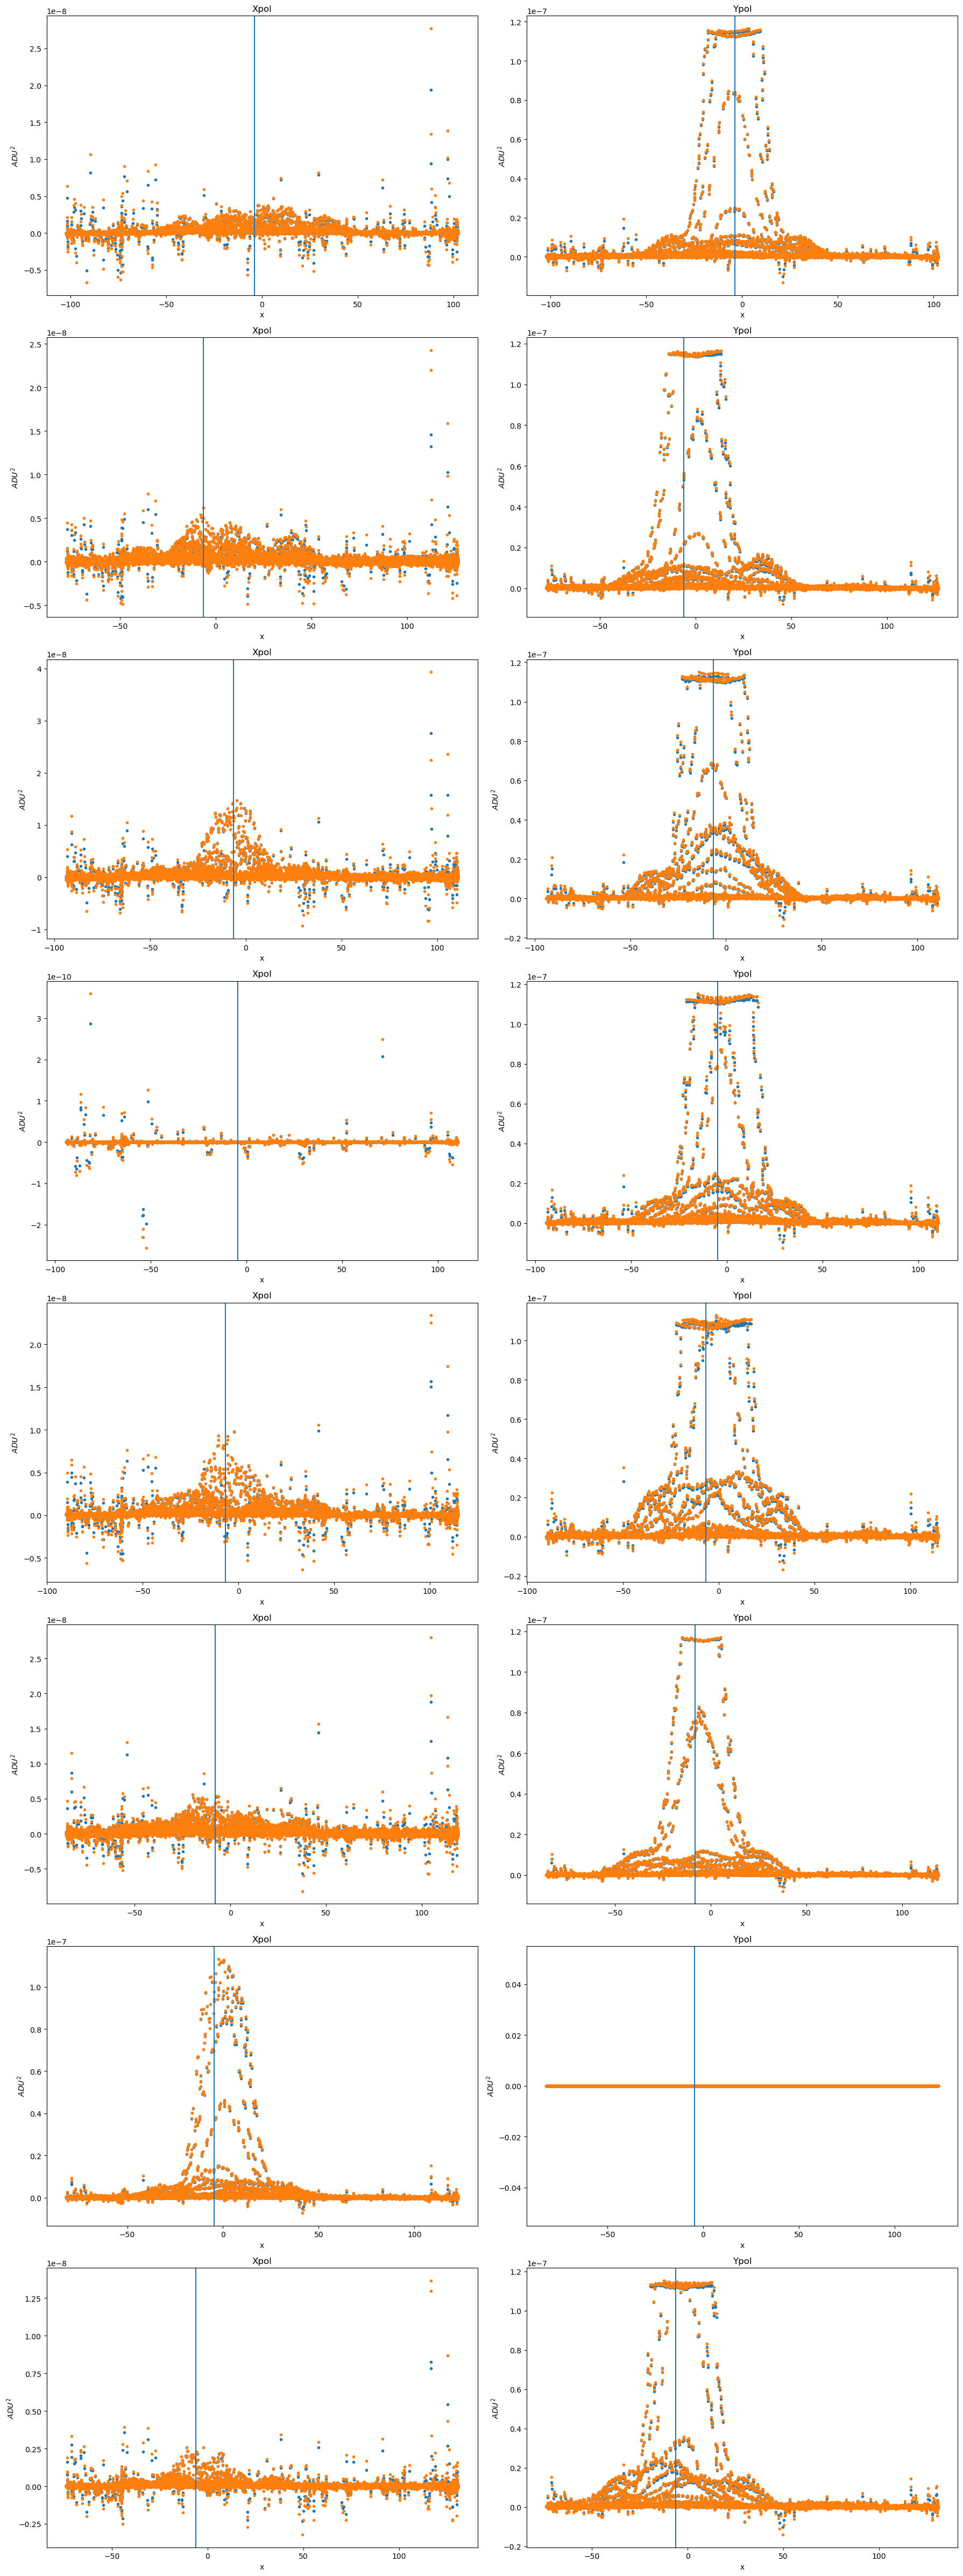

In [122]:
fig,axes=subplots(nrows=8,ncols=2,figsize=(18,48))
for i,k in enumerate([0,2,4,6,8,10,12,14]):
    [ax1,ax2]=axes[i]
    ax1.plot(f533concat.drone_xyz_per_dish_interp[k,:,0][f533concat.inds_on],f533concat.V_bgsub[:,900,k][f533concat.inds_on],'.')
    ax1.plot(f533concat.drone_xyz_per_dish_interp[k,:,0][f533concat.inds_on],dat_corr[:,900,k][f533concat.inds_on],'.')
    ax1.axvline(f533concat.drone_xyz_per_dish_interp[k,mininds[k],0])
    ax2.plot(f533concat.drone_xyz_per_dish_interp[k,:,0][f533concat.inds_on],f533concat.V_bgsub[:,900,k+1][f533concat.inds_on],'.')
    ax2.plot(f533concat.drone_xyz_per_dish_interp[k,:,0][f533concat.inds_on],dat_corr[:,900,k+1][f533concat.inds_on],'.')
    ax2.axvline(f533concat.drone_xyz_per_dish_interp[k,mininds[k],0])
    ax1.set_title('Xpol')
    ax1.set_xlabel('x')
    ax1.set_ylabel('$ADU^2$')
    ax2.set_title('Ypol')
    ax2.set_xlabel('x')
    ax2.set_ylabel('$ADU^2$')
tight_layout()

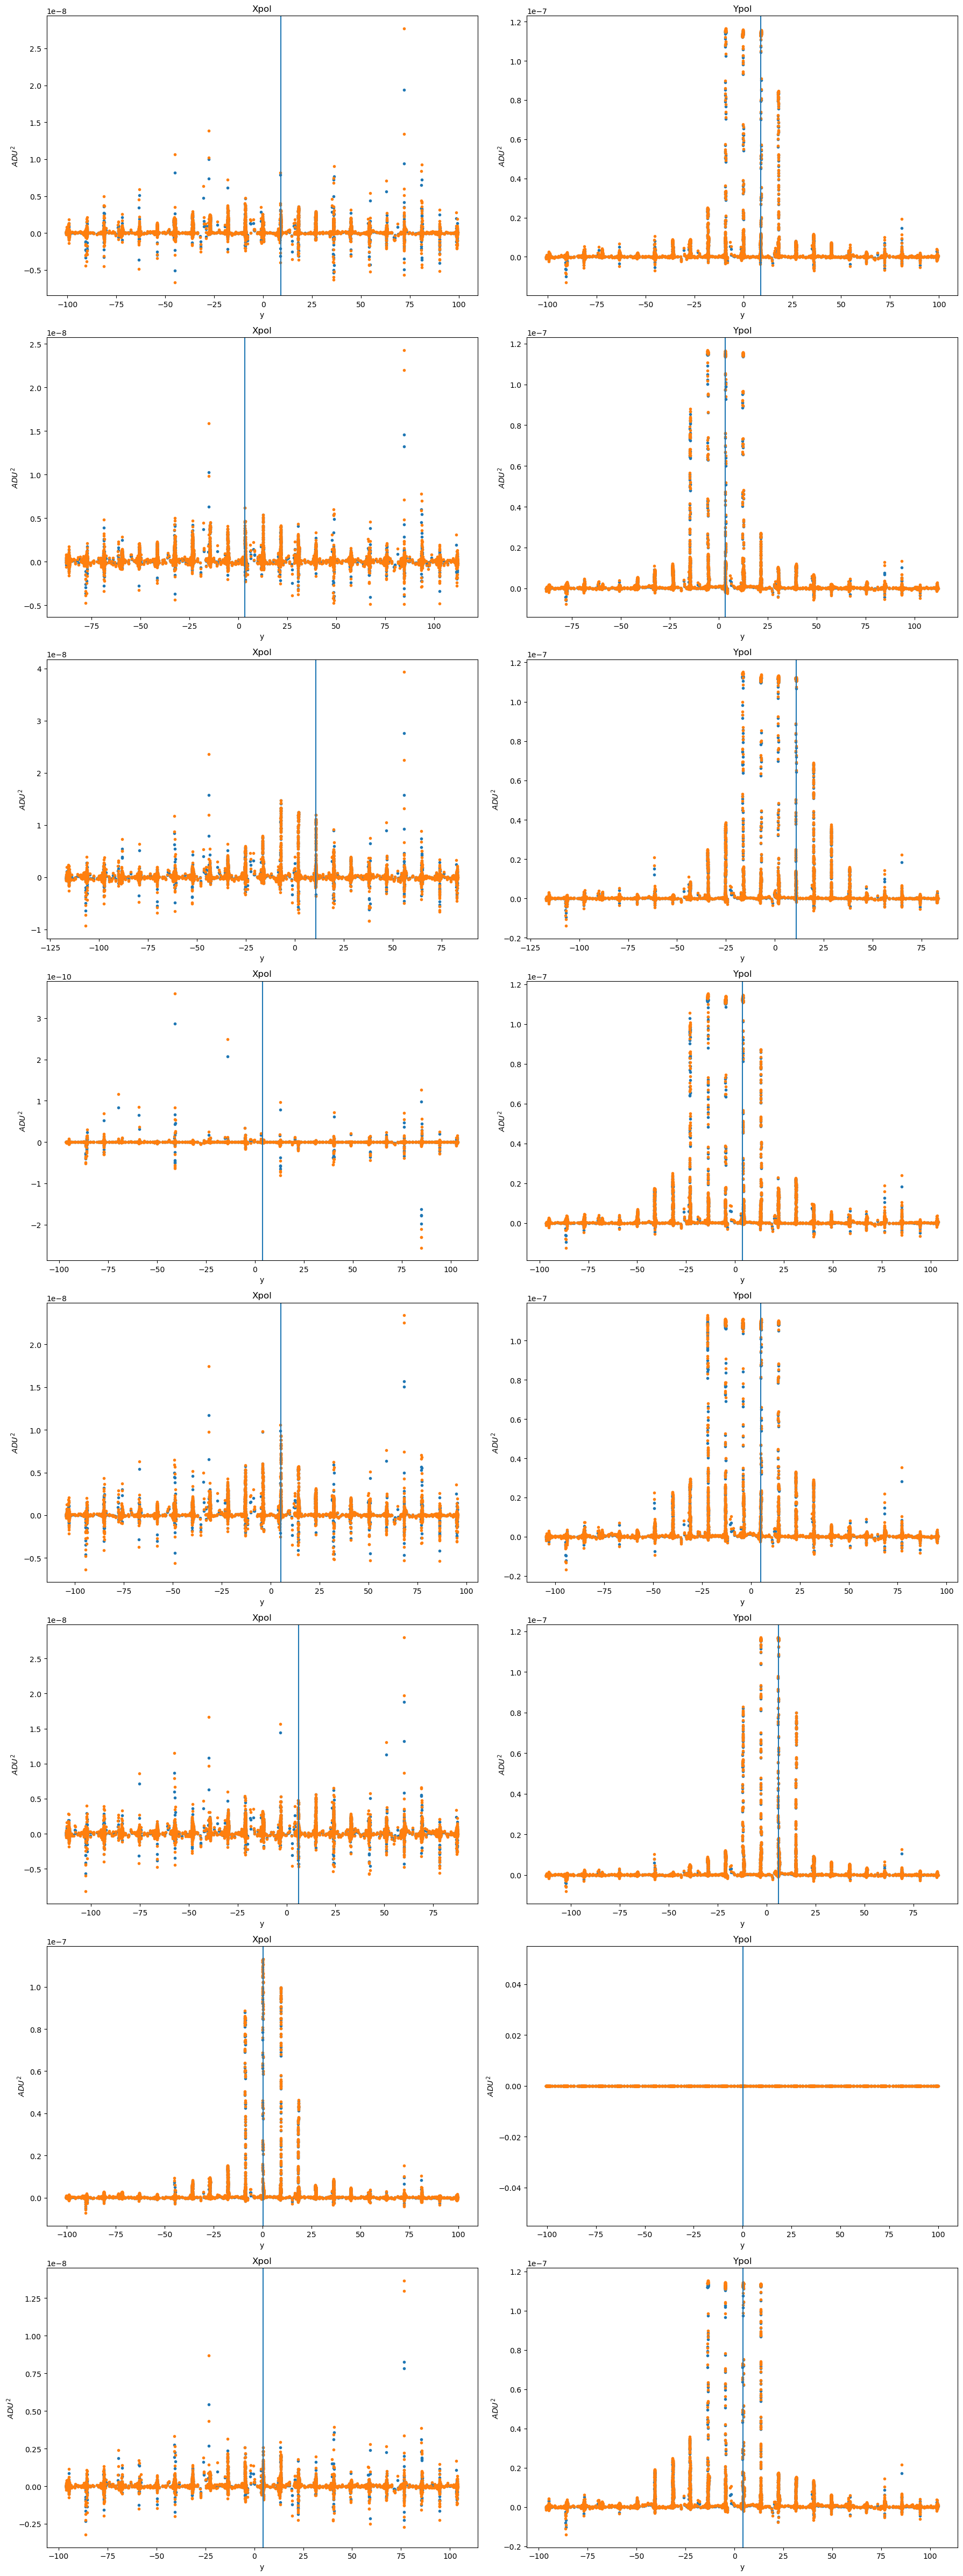

In [123]:
fig,axes=subplots(nrows=8,ncols=2,figsize=(18,48))
for i,k in enumerate([0,2,4,6,8,10,12,14]):
    [ax1,ax2]=axes[i]
    ax1.plot(f533concat.drone_xyz_per_dish_interp[k,:,1][f533concat.inds_on],f533concat.V_bgsub[:,900,k][f533concat.inds_on],'.')
    ax1.plot(f533concat.drone_xyz_per_dish_interp[k,:,1][f533concat.inds_on],dat_corr[:,900,k][f533concat.inds_on],'.')
    ax1.axvline(f533concat.drone_xyz_per_dish_interp[k,mininds[k],1])
    ax2.plot(f533concat.drone_xyz_per_dish_interp[k,:,1][f533concat.inds_on],f533concat.V_bgsub[:,900,k+1][f533concat.inds_on],'.')
    ax2.plot(f533concat.drone_xyz_per_dish_interp[k,:,1][f533concat.inds_on],dat_corr[:,900,k+1][f533concat.inds_on],'.')
    ax2.axvline(f533concat.drone_xyz_per_dish_interp[k,mininds[k],1])
    ax1.set_title('Xpol')
    ax1.set_xlabel('y')
    ax1.set_ylabel('$ADU^2$')
    ax2.set_title('Ypol')
    ax2.set_xlabel('y')
    ax2.set_ylabel('$ADU^2$')
tight_layout()

In [167]:
wee=np.ones((500,10,273))
woo=27.1*np.ones((500,1,1))
weewoo=wee*woo
weewoo.shape

(500, 10, 273)